In [15]:
from mumax_helper import *

from scipy.signal import find_peaks

from pandas import read_csv
import matplotlib.pyplot as plt 
from matplotlib.widgets import Slider, Button


In [23]:
# NUMERICAL PARAMETERS RELEVANT FOR THE SPECTRUM ANALYSIS
fmax = 1e9        # maximum frequency (in Hz) of the sinc pulse
T    = 10e-9        # simulation time (longer -> better frequency resolution)
dt = .8e-10  # the sample time (Nyquist theorem taken into account)


# Note that this is a format string, this means that the statements inside the
# curly brackets get evaluated by python. In this way, we insert the values of
# the variables above in the script.

def resonance_script():

    script = f"""

    setgridsize(300,260,1)
    setcellsize(1e-9,1e-9,1e-9)

    domain := square(300e-9)
    corner1 := rect(150e-9,350-9).transl(140e-9,-30e-9,0).rotz(pi/6)
    corner2 := rect(150e-9,350e-9).transl(-140e-9,-30e-9,0).rotz(-pi/6)
    //corner3 :=  rect(300e-9,50e-9).transl(0,-80e-9,0)
    // corner4 :=  rect(150e-9,300e-9).transl(-150e-9,0,0).rotz(5/6*pi)

    setgeom(domain.sub(corner1).sub(corner2))

    Msat = 1e6
    Aex = 20e-12
    Dind = 3e-3
    Ku1 = 1e6
    AnisU = vector(0,0,1)
    alpha = 0.0001

    dia := 40e-9
    sep := 70e-9
    shape_1 := circle(dia).transl(0, 1.1*sep, 0)
    shape_2 := circle(dia).transl(0, -1.1*sep, 0)

    defregion(1,shape_1)

    B_ext.setRegion(1, vector(0, 0, -.04 + .02 * sin( 2*pi*{fmax}*t)))
    TableAdd(B_ext)


    m = Uniform(0, 0, 1)
    m.setInShape(shape_1, NeelSkyrmion(1, -1).transl(0, sep, 0))
    m.setInShape(shape_2, NeelSkyrmion(1, -1).transl(0, -sep, 0))


    minimize()
    autosave(m,{dt})
    tableautosave({dt})
    run({T})
    """

    return script

run_mumax3(resonance_script(),"Pinned Skyrmion")


0

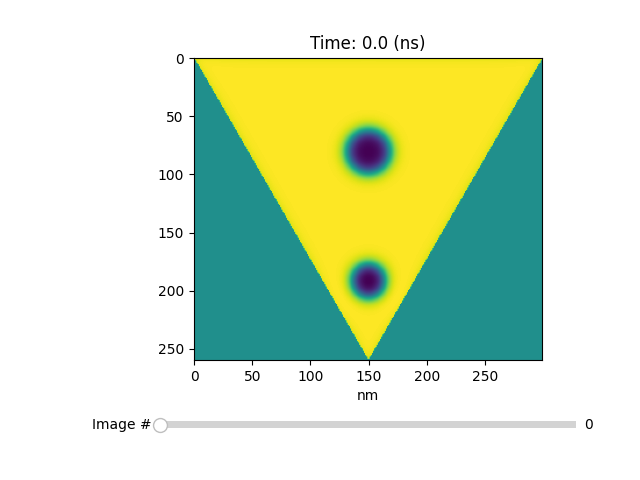

In [22]:
arr = np.load("Pinned Skyrmion.out/m.npz")
table = read_csv('Pinned Skyrmion.out/table.txt',delimiter='\t')
times = table['# t (s)'].values 

%matplotlib widget

# The parametrized function to be plotted
def f(index):
    title = 'arr_'+str(index)
    m = arr[title]
    return m[2,0,:,:]

t = np.linspace(0, 1, 1000)

# Define initial parameters
init_index = 0
title_first = "Time = "
init_title = "Time: " + str(times[init_index]) +" (ns)"

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
line = plt.imshow(f(init_index))
ax.set_xlabel('nm')

ax.set_title(init_title)

# adjust the main plot to make room for the sliders
plt.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control the frequency.
axfreq = plt.axes([0.25, 0.1, 0.65, 0.03])
freq_slider = Slider(
    ax=axfreq,
    label='Image #',
    valmin=0,
    valmax=len(times),
    valstep=1,
    valinit=0,
)

# The function to be called anytime a slider's value changes
def update(val):
    updated_title = "Time: " + str(np.round(times[val]/1e-9,3))+" (ns)"
    line.set_data(f(val))
    fig.canvas.draw_idle()
    ax.set_title(updated_title)


# register the update function with each slider
freq_slider.on_changed(update)